<a href="https://colab.research.google.com/github/aziegert/Fake_news_detection/blob/main/Fake_news_detection_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install ydata-profiling
!python -m spacy download en_core_web_lg
!pip install -U sentence-transformers

In [ ]:
#basic
from google.colab import files
from google.colab import drive
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import datetime
from tqdm import tqdm

#plots
import matplotlib.pyplot as plt
import seaborn as sns

#words
import spacy
import re
from collections import Counter
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

#model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
%matplotlib inline

#Loading data

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 81% 33.0M/41.0M [00:00<00:00, 122MB/s] 
100% 41.0M/41.0M [00:00<00:00, 116MB/s]


In [ ]:
!unzip /content/fake-and-real-news-dataset.zip

Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

#EDA

##Date review

In [ ]:
df_fake['is_fake'] = 1
df_fake.head(5)

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
df_true['is_fake'] = 0
df_true.head(5)

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df = pd.concat([df_fake, df_true]).reset_index(drop=True)
df

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   is_fake  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
#We convert the 'date' column to a date type
df['date_new'] = pd.to_datetime(df['date'], errors='coerce')

# We find all records that are not in the correct format
invalid_dates = df[df['date_new'].isna()]
invalid_dates

,title,text,subject,date,is_fake,date_new
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,NaT
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,1,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,NaT


In [ ]:
df.dropna(subset=['date_new'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     44888 non-null  object        
 1   text      44888 non-null  object        
 2   subject   44888 non-null  object        
 3   date      44888 non-null  object        
 4   is_fake   44888 non-null  int64         
 5   date_new  44888 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.4+ MB


In [ ]:
df.drop('date_new', axis=1, inplace=True)

##Profile Report

In [ ]:
# prof_report = ProfileReport(df_, title='Profile Report-fake news')
# prof_report

##Text statistics

In [ ]:
def basic_plots(df, column, cat):
  fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
  sns.histplot(data=df, x=column, hue=cat, ax=ax1)
  sns.boxplot(data=df, x=cat, y=column, ax=ax2)

###'title' and 'text

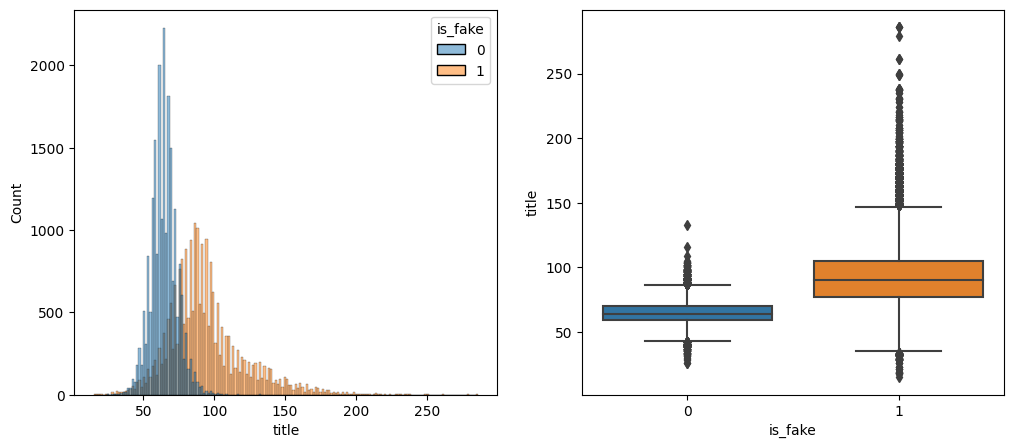

In [ ]:
#the number of charcteristics in the news title
basic_plots(df, df['title'].str.len(), 'is_fake')

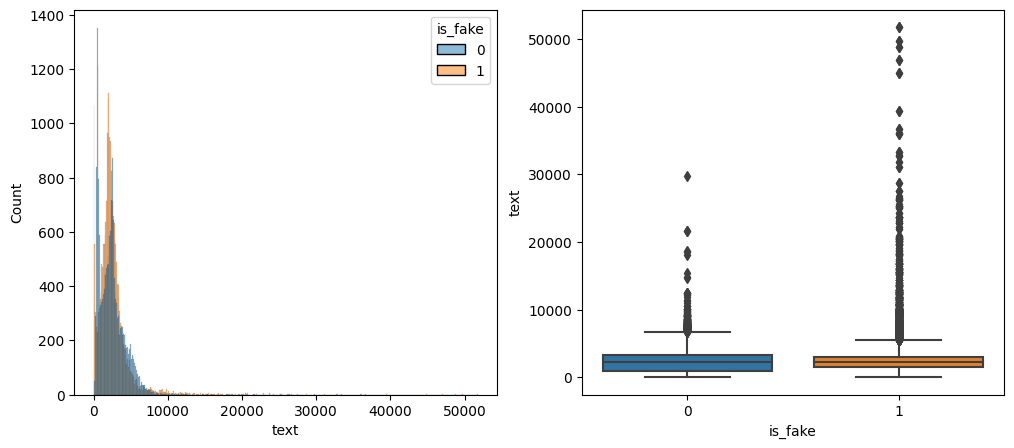

In [ ]:
#the number of charcteristics in the news text
basic_plots(df, df['text'].str.len(), 'is_fake')

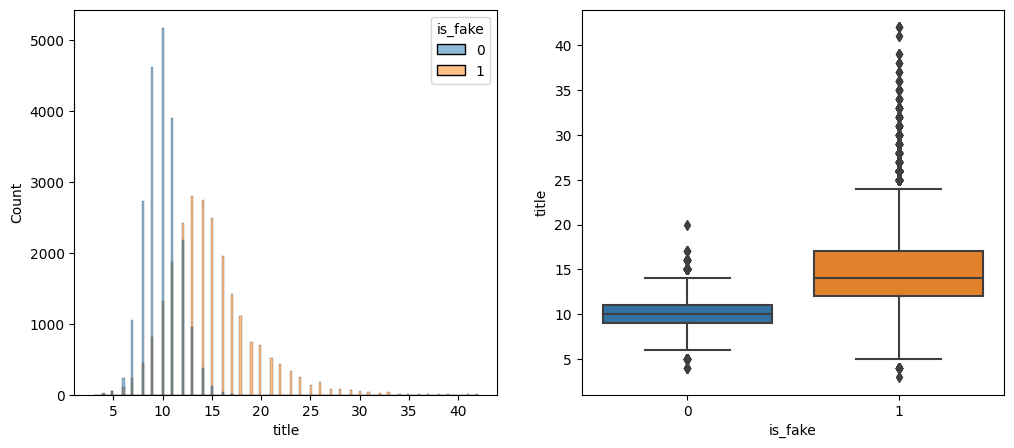

In [ ]:
#the number of word in the news title
basic_plots(df, df['title'].str.split().map(lambda x: len(x)), 'is_fake')

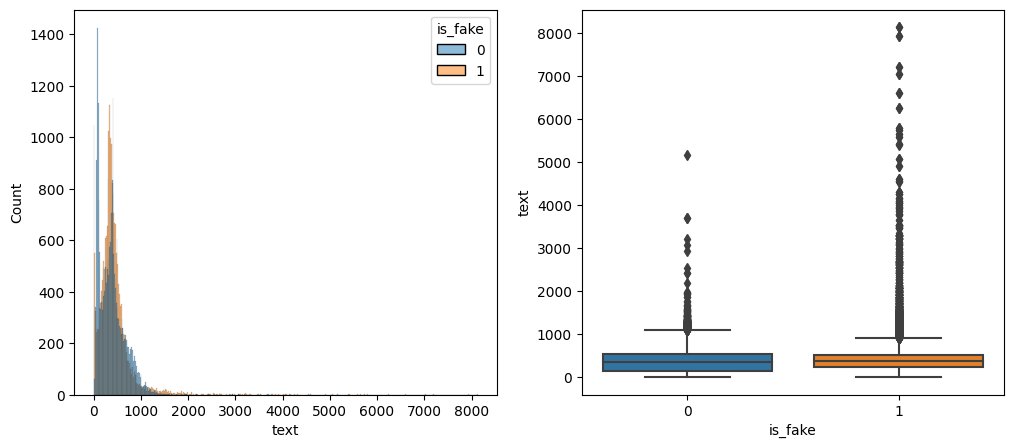

In [ ]:
#the number of word in the news text
basic_plots(df, df['text'].str.split().map(lambda x: len(x)), 'is_fake')

###'date'

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['week_day'] = pd.to_datetime(df['date']).dt.strftime('%A')
df.sample(5)

,title,text,subject,date,is_fake,len_title,week_day
30216,Many Russian officials have good ties with Til...,MOSCOW (Reuters) - Not only Russian President ...,politicsNews,2016-12-13,0,61,Tuesday
39292,A Picture and its Story: Reaching out to rescu...,"PALONG KHALI, Bangladesh (Reuters) - Hannah Mc...",worldnews,2017-11-02,0,64,Thursday
36835,Russian parliament to discuss ban on access fo...,MOSCOW (Reuters) - Russian lawmakers are to di...,worldnews,2017-12-01,0,63,Friday
25557,"Despite expected U.S. troop hike, no end in si...",WASHINGTON (Reuters) - While President Donald ...,politicsNews,2017-08-22,0,63,Tuesday
43011,U.S. 'strongly opposes' Iraqi Kurdish independ...,WASHINGTON (Reuters) - The United States stro...,worldnews,2017-09-20,0,73,Wednesday


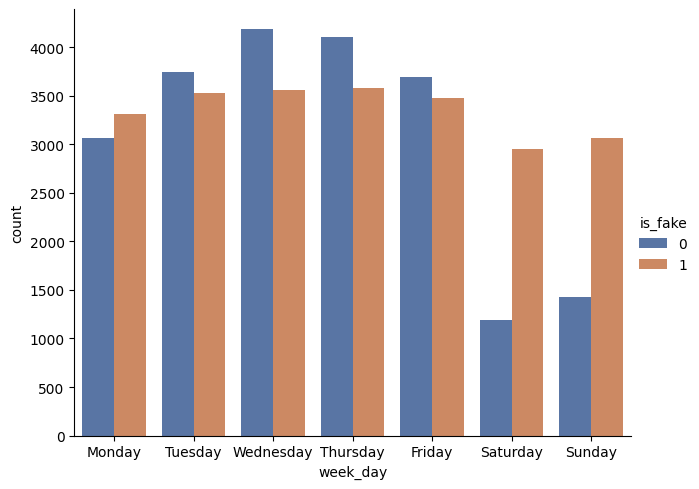

In [ ]:
sns.catplot(data=df, x='week_day', hue='is_fake', kind='count', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], aspect=1.3, palette='deep')

In [ ]:
df['month'] = pd.to_datetime(df['date']).dt.strftime('%m').astype(int)

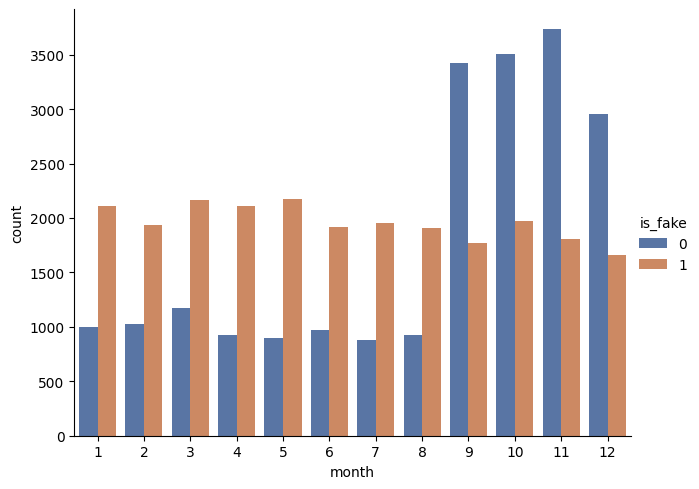

In [ ]:
sns.catplot(data=df, x='month', hue='is_fake', kind='count', aspect=1.3, palette='deep')

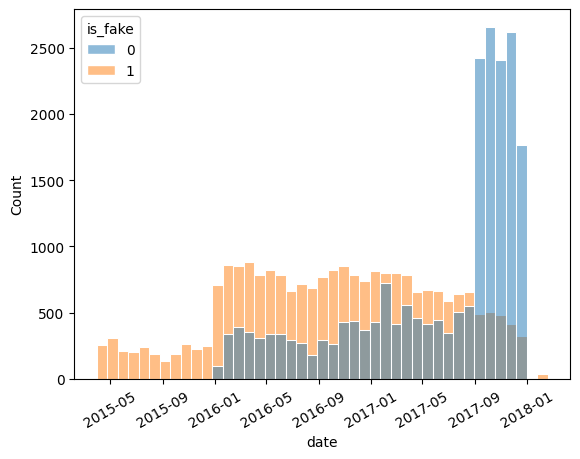

In [ ]:
sns.histplot(data=df, x=df['date'], hue='is_fake', edgecolor='white')
plt.xticks(rotation=30)
plt.show()

###'subject'

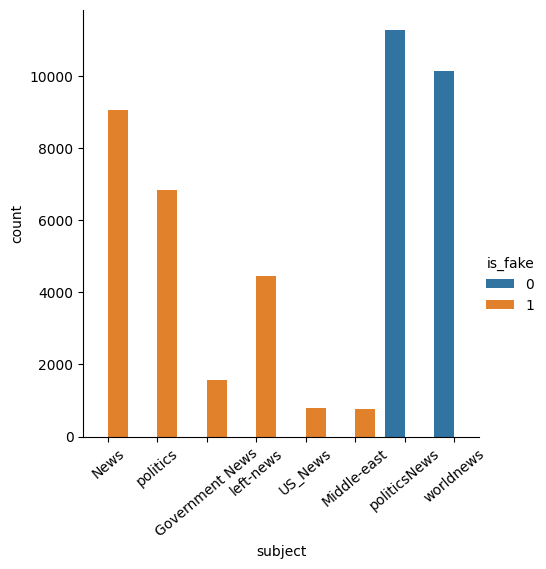

In [ ]:
sns.catplot(data=df, x='subject', hue='is_fake', kind='count')
plt.xticks(rotation=40)
plt.show()

In [ ]:
X_exp = df.iloc[:,0:4]
y_exp = df['is_fake']

In [ ]:
y_exp_pred = []
for sub in X_exp['subject']:
    if sub in ['politicsNews', 'worldnews']:
        y_exp_pred.append(0)
    else:
        y_exp_pred.append(1)

accuracy_score(y_exp, y_exp_pred)

1.0

In [ ]:
cf_matrix = confusion_matrix(y_exp, y_exp_pred)
cf_matrix

array([[21417,     0],
       [    0, 23471]])

IN PRINCIPLE, WE CAN FINISH WORKING ON THE MODEL AT THIS POINT. OUR PREDICTION IS 100%.

##Text Cleaning and Embeddings

###Cleaning

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
tqdm.pandas()

In [ ]:
def clean_text(text):
  
  clean_text = []
  text = re.sub(r'@\S+', '', text)
  text = nlp(text)
  
  for token in text:
    token.norm_
    token.lemma_
        
    if not (token.is_stop
            or token.is_digit
            or token.is_punct
            or token.like_url
            or token.like_email
            or token.is_space
            or token.is_oov
            or len(token)<2) :

      clean_text.append(token.text)  
     
  return " ".join(clean_text)

In [ ]:
df['title_progress'] = df['title'].progress_apply(clean_text)
df.sample(5)

100%|██████████| 44888/44888 [08:05<00:00, 92.41it/s]


,title,text,subject,date,is_fake,len_title,week_day,month,title_progress
40007,Kenya election board head: elections will go a...,NAIROBI (Reuters) - Kenya s repeat presidentia...,worldnews,2017-10-25,0,72,Wednesday,10,Kenya election board head elections ahead Thur...
39274,China disputes Trump's claims of fentanyl 'flo...,BEIJING (Reuters) - China s drug control agenc...,worldnews,2017-11-03,0,68,Friday,11,China disputes Trump claims fentanyl flood Uni...
28613,Pence says his private email use was not the s...,WASHINGTON (Reuters) - U.S. Vice President Mik...,politicsNews,2017-03-03,0,62,Friday,3,Pence says private email use Clinton
15709,(VIDEO) LIBERAL PUNDIT: OBAMA WORST POTUS EVER,,politics,2015-05-12,1,46,Tuesday,5,VIDEO LIBERAL OBAMA WORST POTUS
34127,Republican Sandoval withdraws as possible Supr...,WASHINGTON (Reuters) - Nevada Governor Brian S...,politicsNews,2016-02-25,0,60,Thursday,2,Republican Sandoval withdraws possible Supreme...


In [ ]:
df['text_progress'] = df['text'].progress_apply(clean_text)
df.sample(5)

100%|██████████| 44888/44888 [1:02:34<00:00, 11.95it/s]


,title,text,subject,date,is_fake,len_title,week_day,month,title_progress,title_emb,text_progress
18260,SNOPES IMPLODES! Liberal “Fact-Checker” Turns ...,Where s George Soros when his top fact check...,left-news,2017-07-24,1,85,Monday,7,Liberal Fact Checker Turns GoFundMe Business A...,"[0.041836258, -0.08461123, -0.029980937, 0.052...",George Soros fact checkers aka conservative ne...
10205,UNIV Of GA PROFESSOR Allows Students To CHOOSE...,A University of Georgia professor has adopted ...,politics,2017-08-08,1,88,Tuesday,8,UNIV GA PROFESSOR Allows Students CHOOSE GRADE...,"[-0.084829874, 0.065057464, -0.012023541, 0.05...",University Georgia professor adopted stress re...
13196,LIBERAL MEDIA GETS HAMMERED At Rally By Trump ...,Trump supporters chanted at the press before a...,politics,2016-08-22,1,92,Monday,8,LIBERAL MEDIA GETS Rally Trump Supporters Chan...,"[0.0753418, -0.043709405, 0.02224271, -0.07446...",Trump supporters chanted press Trump rally Fre...
38973,Philippine drugs board chief quits after contr...,MANILA (Reuters) - The head of the Philippines...,worldnews,2017-11-07,0,62,Tuesday,11,Philippine drugs board chief quits contradicti...,"[0.056754638, -0.024646185, -0.001160243, -0.1...",MANILA Reuters head Philippines narcotics cont...
13118,KAINE GETS TRIPPED UP Trying To Explain Away H...,,politics,2016-09-01,1,87,Thursday,9,GETS Trying Explain Away Hillary Absence Video,"[0.033084653, -0.06547941, 0.021378364, 0.0558...",


###Most common words

In [ ]:
def creat_corpus(column, is_fake):
  corpus = []

  if is_fake in [0,1]:
    dfc = df[df['is_fake']==is_fake][column]
  else:
    dfc = df[column]

  for news in dfc.str.split():
    for word in news:
      corpus.append(word.lower())

  counter = Counter(corpus)
  most = counter.most_common()
  df_most = pd.DataFrame(most, columns=['word', 'count'])

  return df_most, corpus

In [ ]:
most_title, corpus_title = creat_corpus('title_progress', 3)
most_text, corpus_text = creat_corpus('text_progress', 3)
most_fake_title, corpus_fake_title = creat_corpus('title_progress', 1)
most_fake_text, corpus_fake_text = creat_corpus('text_progress', 1)
most_real_title, corpus_real_title = creat_corpus('title_progress', 0)
most_real_text, corpus_real_text = creat_corpus('text_progress', 0)

Text(0.5, 1.0, 'The most common words in the title')

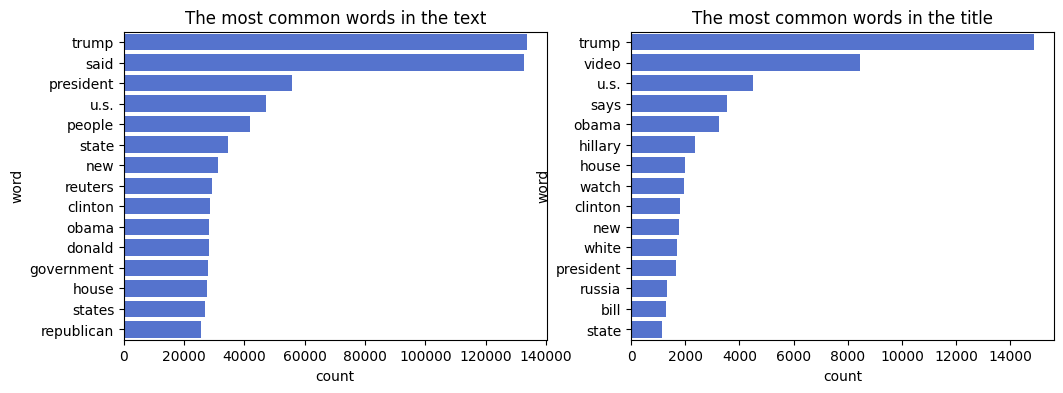

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.barplot(x=most_text['count'][:15],
            y=most_text['word'][:15],
            ax=ax1,
            color='royalblue').set_title('The most common words in the text')

sns.barplot(x=most_title['count'][:15],
            y=most_title['word'][:15],
            ax=ax2,
            color='royalblue').set_title('The most common words in the title')

Text(0.5, 1.0, 'The most common words in the fake news')

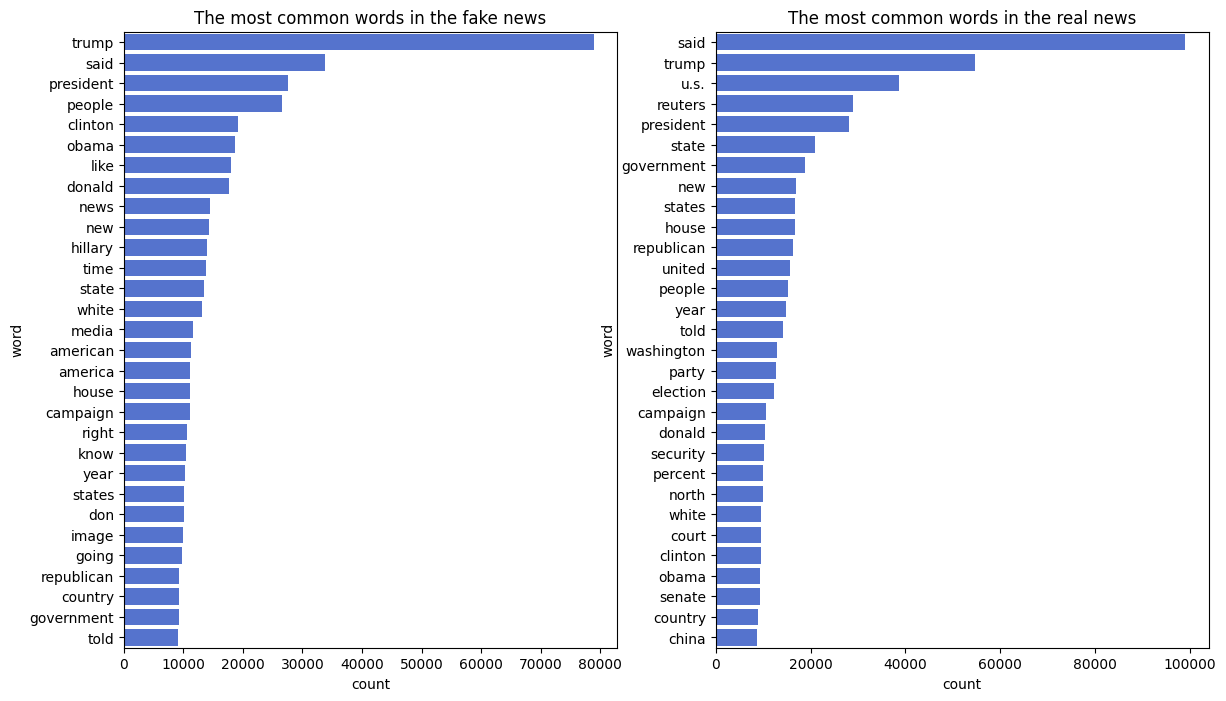

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,8))

sns.barplot(x=most_real_text['count'][:30],
            y=most_real_text['word'][:30],
            ax=ax2,
            color='royalblue').set_title('The most common words in the real news')

sns.barplot(x=most_fake_text['count'][:30],
            y=most_fake_text['word'][:30],
            ax=ax1,
            color='royalblue').set_title('The most common words in the fake news')



###WordCloud

(-0.5, 3499.5, 2499.5, -0.5)

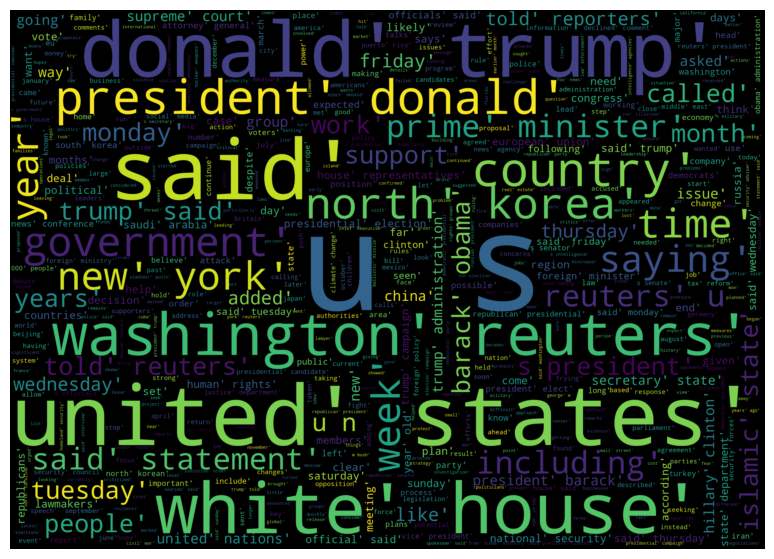

In [ ]:
plt.figure(figsize = (12,7))
wordcloud = WordCloud(max_words=1000,
                      width = 700,
                      height = 500,
                      scale=5,
                      random_state=6)

wordcloud = wordcloud.generate(str(corpus_real_text))

plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis('off')

(-0.5, 3499.5, 2499.5, -0.5)

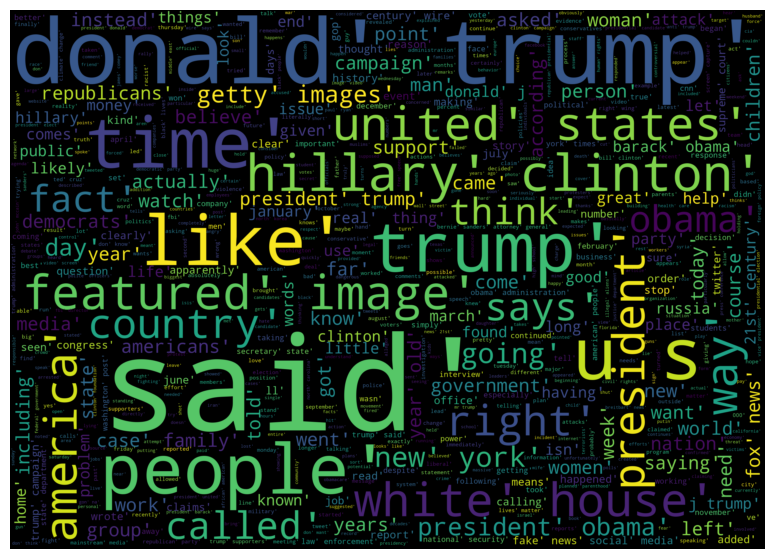

In [ ]:
plt.figure(figsize = (12,7))
wordcloud = WordCloud(max_words=1000,
                      width = 700,
                      height = 500,
                      scale=5,
                      random_state=6)

wordcloud = wordcloud.generate(str(corpus_fake_text))

plt.imshow(wordcloud , interpolation = 'bilinear')
plt.axis('off')

###Embeddings

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
df['title_emb'] = df['title_progress'].progress_apply(lambda x: model.encode(x))

100%|██████████| 44888/44888 [20:29<00:00, 36.51it/s]


In [ ]:
df['text_emb'] = df['text_progress'].progress_apply(lambda x: model.encode(x))

100%|██████████| 44888/44888 [1:19:11<00:00,  9.45it/s]


#Splitting our dataset into a train/validation/test split

In [ ]:
class TextDataset(Dataset):
  def __init__(self, vectors, labels):
    self.vectors = vectors
    self.labels = labels
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, idx):
    return self.vectors[idx], self.labels[idx]

In [ ]:
def get_dataloaders(X, y, batch_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)   

  X_train, X_val, X_test = torch.Tensor(X_train.tolist()), torch.Tensor(X_val.tolist()), torch.Tensor(X_test.tolist())
  y_train, y_val, y_test = torch.Tensor(y_train.values), torch.Tensor(y_val.values), torch.Tensor(y_test.values)

  train_data = TextDataset(X_train, y_train)
  val_data = TextDataset(X_val, y_val)
  test_data = TextDataset(X_test, y_test)

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return  train_dataloader, val_dataloader, test_dataloader

#Logistic Regression

In [ ]:
class LogisticRegression(torch.nn.Module):

  def __init__(self, n_inputs, n_outputs):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(n_inputs, n_outputs)

  def forward(self, x):
    y_pred = torch.sigmoid(self.linear(x))
    return y_pred

In [ ]:
n_inputs = 384
n_outputs = 1
learning_rate = 0.001

log_reg = LogisticRegression(n_inputs, n_outputs)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(log_reg.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct, correct_sum = 0, 0, 0

    for batch, (vectors, labels) in enumerate(dataloader):
        
      # Compute prediction and loss
      outputs = model(vectors)
      loss = loss_fn(outputs, labels.unsqueeze(1))

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss +=loss.item()
      predicted = torch.round(outputs)
      correct = torch.eq(predicted, labels.unsqueeze(1)).sum()
      correct_sum += correct.item()

    train_loss /= num_batches
    accuracy = 100 * correct_sum / size
    print(f'Loss: {train_loss:.6f},  Accuracy: {accuracy:.2f}%', end='    ')

    return train_loss, accuracy


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_sum = 0, 0, 0

    with torch.no_grad():
        for vectors, labels in dataloader:
            outputs = model(vectors)
            test_loss += loss_fn(outputs, labels.unsqueeze(1)).item()
            predicted = torch.round(outputs)
            correct = torch.eq(predicted, labels.unsqueeze(1)).sum()
            correct_sum += correct.item()

    test_loss /= num_batches
    accuracy = 100 * correct_sum / size
    print(f'Loss: {test_loss:.6f},  Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

##Prediction based on 'title'

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['title_emb'], df['is_fake'], batch_size=500)

<ipython-input-47-af861c22a8de>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train, X_val, X_test = torch.Tensor(X_train.tolist()), torch.Tensor(X_val.tolist()), torch.Tensor(X_test.tolist())


In [ ]:
log_reg.linear.reset_parameters()

epochs = 200
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, log_reg, loss_fn, optimizer)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, log_reg, loss_fn)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_log_reg_model = log_reg
        torch.save(log_reg.state_dict(), 'best_log_reg_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.616384,  Accuracy: 73.50%    Validation: Loss: 0.543923,  Accuracy: 82.08%
Epoch 2:  Train: Loss: 0.507626,  Accuracy: 83.80%    Validation: Loss: 0.472913,  Accuracy: 85.53%
Epoch 3:  Train: Loss: 0.455603,  Accuracy: 85.11%    Validation: Loss: 0.433527,  Accuracy: 86.04%
Epoch 4:  Train: Loss: 0.424102,  Accuracy: 85.53%    Validation: Loss: 0.407817,  Accuracy: 86.53%
Epoch 5:  Train: Loss: 0.402511,  Accuracy: 85.82%    Validation: Loss: 0.389212,  Accuracy: 86.79%
Epoch 6:  Train: Loss: 0.386465,  Accuracy: 86.07%    Validation: Loss: 0.374970,  Accuracy: 87.03%
Epoch 7:  Train: Loss: 0.373858,  Accuracy: 86.28%    Validation: Loss: 0.363638,  Accuracy: 87.20%
Epoch 8:  Train: Loss: 0.363559,  Accuracy: 86.53%    Validation: Loss: 0.354258,  Accuracy: 87.45%
Epoch 9:  Train: Loss: 0.355025,  Accuracy: 86.74%    Validation: Loss: 0.346310,  Accuracy: 87.55%
Epoch 10:  Train: Loss: 0.347695,  Accuracy: 86.87%    Validation: Loss: 0.339469,  Accuracy: 87.59%

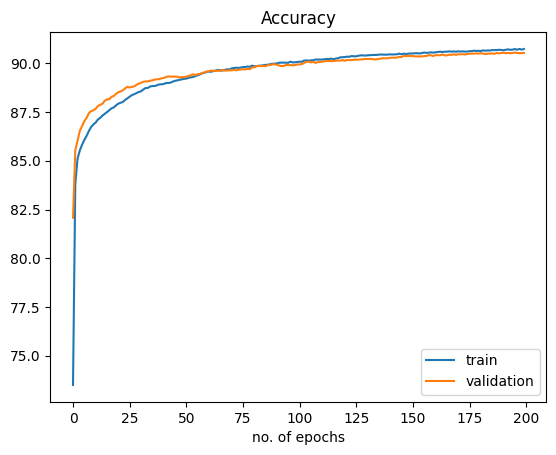

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

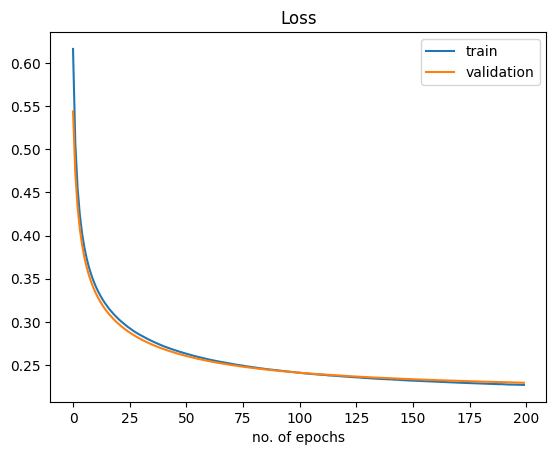

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_title_model = best_log_reg_model
test_loss, test_accuracy = test_loop(test_dataloader, best_title_model, loss_fn)

Loss: 0.234187,  Accuracy: 90.25%


##Prediction based on 'text'

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df['text_emb'], df['is_fake'], batch_size=64)

In [ ]:
log_reg.linear.reset_parameters()

epochs = 200
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:  ', end='')
    print(f'Train: ', end='')
    train_loss, train_accuracy = train_loop(train_dataloader, log_reg, loss_fn, optimizer)
    print(f'Validation: ', end='')
    val_loss, val_accuracy = test_loop(val_dataloader, log_reg, loss_fn)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_log_reg_model = log_reg
        torch.save(log_reg.state_dict(), 'best_log_reg_model.pt')

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

print('Done!')

Epoch 1:  Train: Loss: 0.403822,  Accuracy: 88.68%    Validation: Loss: 0.306530,  Accuracy: 91.39%
Epoch 2:  Train: Loss: 0.281078,  Accuracy: 91.45%    Validation: Loss: 0.255528,  Accuracy: 92.29%
Epoch 3:  Train: Loss: 0.245434,  Accuracy: 92.25%    Validation: Loss: 0.229926,  Accuracy: 92.95%
Epoch 4:  Train: Loss: 0.224739,  Accuracy: 92.74%    Validation: Loss: 0.213333,  Accuracy: 93.28%
Epoch 5:  Train: Loss: 0.210396,  Accuracy: 93.08%    Validation: Loss: 0.201326,  Accuracy: 93.60%
Epoch 6:  Train: Loss: 0.199479,  Accuracy: 93.29%    Validation: Loss: 0.191610,  Accuracy: 93.78%
Epoch 7:  Train: Loss: 0.190762,  Accuracy: 93.51%    Validation: Loss: 0.183895,  Accuracy: 93.87%
Epoch 8:  Train: Loss: 0.183536,  Accuracy: 93.69%    Validation: Loss: 0.177536,  Accuracy: 94.02%
Epoch 9:  Train: Loss: 0.177423,  Accuracy: 93.87%    Validation: Loss: 0.172009,  Accuracy: 94.11%
Epoch 10:  Train: Loss: 0.172151,  Accuracy: 94.06%    Validation: Loss: 0.167328,  Accuracy: 94.22%

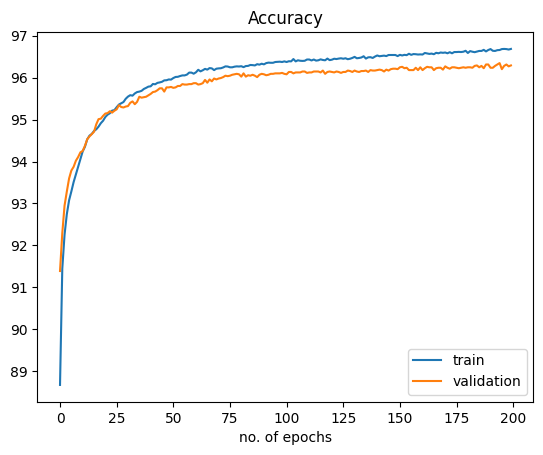

In [ ]:
#Plot of Accuracy
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel("no. of epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

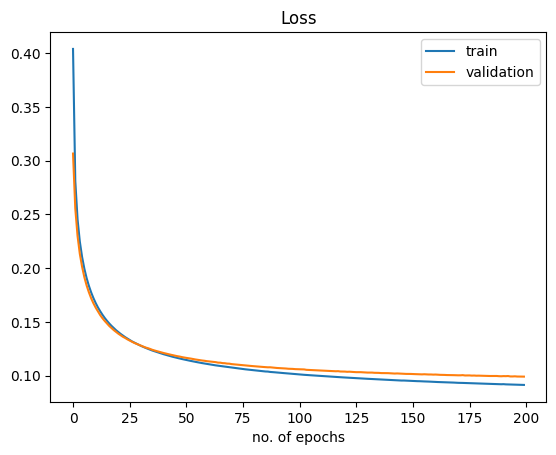

In [ ]:
#Plot of Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('no. of epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
best_text_model = best_log_reg_model
test_loss, test_accuracy = test_loop(test_dataloader, best_text_model, loss_fn)

Loss: 0.097265,  Accuracy: 96.16%


#Summary

>The best prediction was obtained without building a model, only based on the topic of the news: 'subject'.

>Based on the logistic regression model, two models were built: one using the 'title' column and the other using the 'text' column. Both columns were previously cleaned and then transformed into vectors using the Spacy library. 

>The best prediction was obtained in the second model. On the test set, the accuracy is 96.16%.